In [1]:
import exploratoryAnalysis as ea

db = ea.CarLogDB("www/wsgi-scripts/carLog.db")
data = ea.MileageData(db.getAllMileageByVehicleId(1))
nameFromDestId = db.getAllDestinations()
db.close()

est = ea.Estimator(data)
summary = ea.Summarizer(data)

In [2]:
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import numpy

uniqueDestIds = nameFromDestId.keys()
uniqueColors = cm.rainbow(numpy.linspace(0, 1, len(uniqueDestIds)))
colorFromDestId = { destId : color for (destId, color) in zip(uniqueDestIds, uniqueColors) }
destinationHandles = map(lambda x : mpatches.Patch(color=colorFromDestId[x], label=nameFromDestId[x]), uniqueDestIds)

destinationNames = map(lambda x : nameFromDestId[x], data.destinationIds)
colors = map(lambda x : colorFromDestId[x], data.destinationIds)

# Trip Mileage
Trip mileage is the distance traveled since the last gas refill. Assumed that the trip mileage is always reset to zero between refills, and that the maximum distance is traveled given a full tank of gas between refills. 

{'loc': 283.81634974414516, 'quantiles': array([ 216.44,  276.4 ,  302.52]), 'scale': 40.320155495089303, 'maximum': 332.69999999999999, 'interval': (135.58948866503712, 336.44716563105902)}


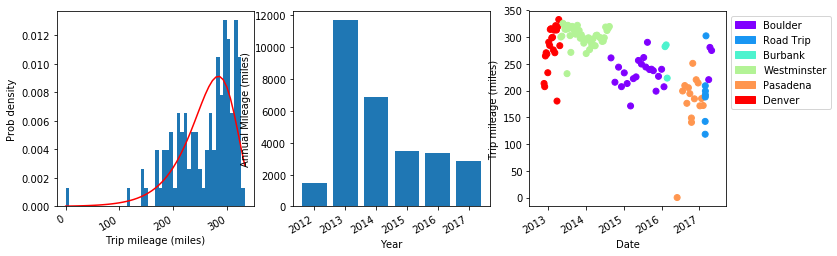

In [3]:
params = est.getParameters(data.tripMileage)
dateBins, annualMileage = summary.groupByYear(data.toDates, data.tripMileage)
print params

f, axes = plot.subplots(1, 3)
f.autofmt_xdate()
f.set_size_inches(12, 4)

binValues, bins, patches = axes[0].hist(data.tripMileage, bins=50, normed=True)
Y = est.getPdf(data.tripMileage, bins)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Trip mileage (miles)")
axes[0].set_ylabel("Prob density")

axes[1].bar(dateBins, map(lambda x : annualMileage[x], dateBins))
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Annual Mileage (miles)")
axes[1].set_xticks(dateBins)

axes[2].scatter(data.toDates, data.tripMileage, c = colors)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Trip mileage (miles)")
axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Refill
The assumption here is that the vehicle is driven until the tank is near empty and that the amount of gas purchased fills the tank completely (no partial refills.)

{'loc': 11.217334654295254, 'quantiles': array([ 10.4216,  11.187 ,  11.579 ]), 'scale': 0.94630902539680495, 'maximum': 12.273999999999999, 'interval': (7.738468694502961, 12.45257334512446)}


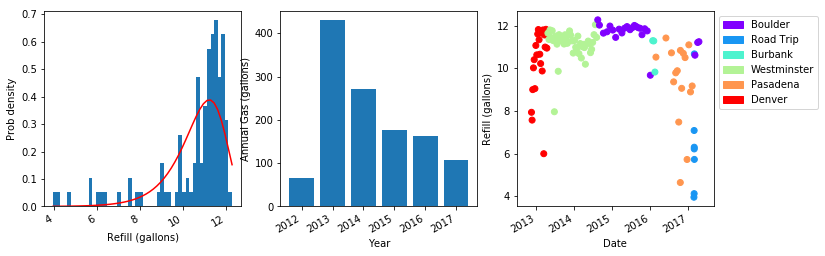

In [4]:
params = est.getParameters(data.gallons)
dateBins, annualGallons = summary.groupByYear(data.fromDates, data.gallons)
print params

f, axes = plot.subplots(1, 3)
f.autofmt_xdate()
f.set_size_inches(12, 4)

binValues, bins, patches = axes[0].hist(data.gallons, bins=50, normed=True)
Y = est.getPdf(data.gallons, bins)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Refill (gallons)")
axes[0].set_ylabel("Prob density")

axes[1].bar(dateBins, map(lambda x : annualGallons[x], dateBins))
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Annual Gas (gallons)")
axes[1].set_xticks(dateBins)

axes[2].scatter(data.fromDates, data.gallons, c = colors)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Refill (gallons)")
axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Extended Amount
Cost to fill up the vehicle with gas each time

{'loc': 35.489466655252869, 'quantiles': array([ 25.78195  ,  33.018239 ,  38.5251794]), 'scale': 6.5307107077648929, 'maximum': 45.304039000000003, 'interval': (11.480959323340205, 44.014151856750495)}


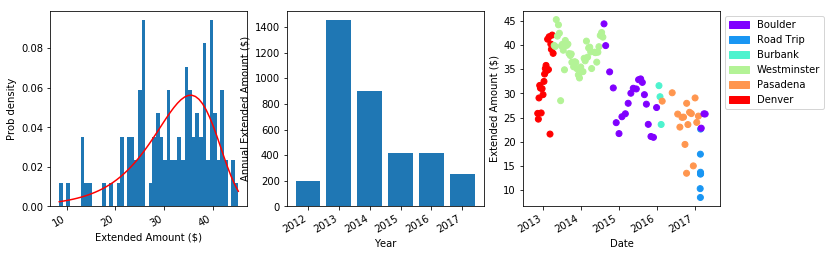

In [5]:
params = est.getParameters(data.extendedAmounts)
dateBins, annualEA = summary.groupByYear(data.fromDates, data.extendedAmounts)
print params

f, axes = plot.subplots(1, 3)
f.autofmt_xdate()
f.set_size_inches(12, 4)

binValues, bins, patches = axes[0].hist(data.extendedAmounts, bins=50, normed=True)
Y = est.getPdf(data.extendedAmounts, bins)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Extended Amount ($)")
axes[0].set_ylabel("Prob density")

axes[1].bar(dateBins, map(lambda x : annualEA[x], dateBins))
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Annual Extended Amount ($)")
axes[1].set_xticks(dateBins)

axes[2].scatter(data.fromDates, data.extendedAmounts, c = colors)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Extended Amount ($)")
axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()


# Trip Mileage and Tank Size correlation

Pearson R:  (0.53242593391926041, 9.1115447526556011e-10)


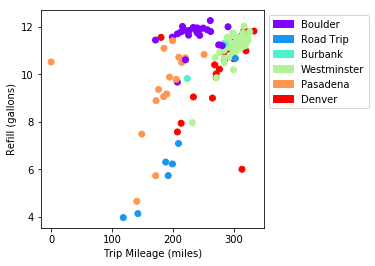

In [6]:
import scipy.stats
print "Pearson R: ", scipy.stats.pearsonr(data.tripMileage, data.gallons)

f, axes = plot.subplots(1, 1)
f.set_size_inches(4, 4)

axes.scatter(data.tripMileage, data.gallons, c = colors)
axes.set_xlabel("Trip Mileage (miles)")
axes.set_ylabel("Refill (gallons)")
axes.legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# MPG
Average miles driven per gallon given a trip. Assumes bimodal distribution since there may be periods where city travel is more frequent than highway travel.

0.523270850324 [ 22.96530912] 43.7113745318
0.476729149676 [ 27.03570853] 1.12136441987


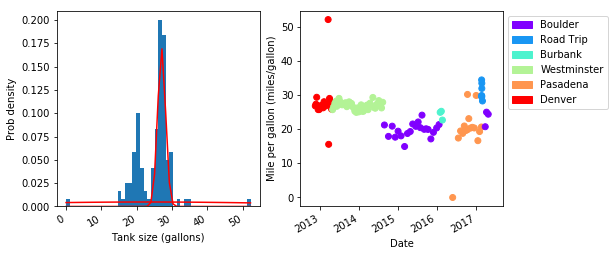

In [7]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type="spherical", n_init=20, init_params="random")
gmm.fit(numpy.array(data.mpg).reshape(-1,1))

f, axes = plot.subplots(1, 2)
f.autofmt_xdate()
f.set_size_inches(8, 4)

binValues, bins, patches = axes[0].hist(data.mpg, bins=50, normed=True)
axes[0].set_xlabel("Tank size (gallons)")
axes[0].set_ylabel("Prob density")

for pi, mu, sigma in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    print pi, mu, sigma
    Y = pi * scipy.stats.norm.pdf(bins, mu[0], sigma)
    axes[0].plot(bins, Y, c='r')

axes[1].scatter(data.toDates, data.mpg, c = colors)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Mile per gallon (miles/gallon)")
axes[1].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# PPM
Only accounts for previous cost of gas added to tank- does not try to do any fifo or mixture accounting of previously added gas left in the tank 

{'loc': 0.12147053823760907, 'quantiles': array([ 0.11375682,  0.12442904,  0.13006949]), 'scale': 0.022803227862223118, 'maximum': 0.23083103716028841, 'interval': (0.07677703289639147, 0.16616404357882669)}


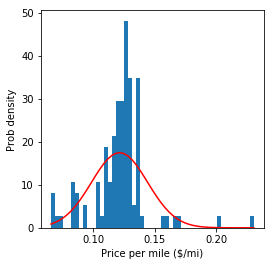

In [8]:
params = est.getParameters(data.ppm)
print params

f, axes = plot.subplots(1, 1)
f.set_size_inches(4, 4)

binValues, bins, patches = axes.hist(data.ppm, bins=50, normed=True)
Y = est.getPdf(data.ppm, bins)
axes.plot(bins, Y, c='r')
axes.set_xlabel("Price per mile ($/mi)")
axes.set_ylabel("Prob density")

plot.show()

# Days between refills
TODO

{'loc': 10.004934909699124, 'quantiles': array([  8.2,  11. ,  16.8]), 'scale': 6.6154072986828725, 'maximum': 96.0, 'interval': (1.3696933219941965, 34.324807851732075)}


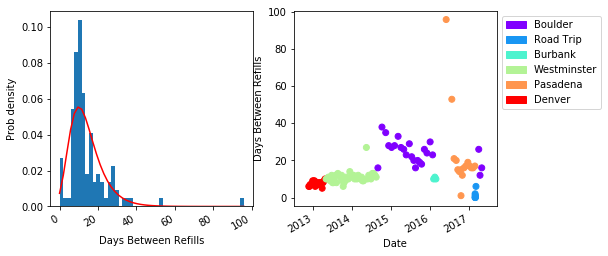

In [9]:
params = est.getParameters(data.daysBetween)
print params

f, axes = plot.subplots(1, 2)
f.autofmt_xdate()
f.set_size_inches(8, 4)

binValues, bins, patches = axes[0].hist(data.daysBetween, bins=50, normed=True)
Y = est.getPdf(data.daysBetween, bins)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Days Between Refills")
axes[0].set_ylabel("Prob density")

axes[1].scatter(data.toDates, data.daysBetween, c = colors)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Days Between Refills")
axes[1].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Timemap

Ref: http://ieeexplore.ieee.org/document/7363824

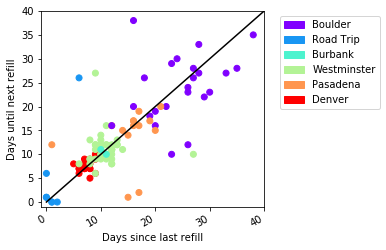

In [10]:
f, axes = plot.subplots(1, 1)
f.autofmt_xdate()
f.set_size_inches(4, 4)

maxX = numpy.max(data.daysBetween)

axes.plot([0,maxX],[0,maxX], c='black')
axes.scatter(data.daysBetween[:-1], data.daysBetween[1:], c = colors)
axes.set_xlabel("Days since last refill")
axes.set_ylabel("Days until next refill")
axes.set_xlim(-1, 40)
axes.set_ylim(-1, 40)
axes.legend(bbox_to_anchor=(1.05, 1), handles=destinationHandles)

plot.show()

# PPG
Goal: given the data on hand, can the future price per gallon at the pump be predicted accurately?
It is assumed that the same grade of gas was used throughout

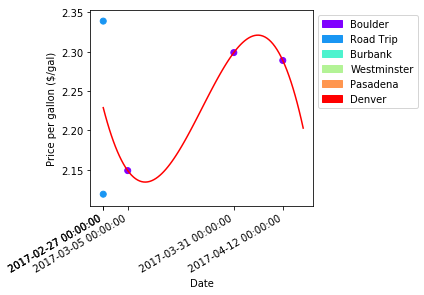

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

numPoints = 5
minDate = min(data.fromDates)

X = numpy.array(map(lambda x : (x - minDate).total_seconds() / 60 / 60 / 24, data.fromDates)).reshape(-1, 1)[-numPoints:]
Y = data.pricePerGallon[-numPoints:]

pf = PolynomialFeatures(numPoints)
model = LinearRegression()
model.fit(pf.fit_transform(X), Y)

forecastX = numpy.array(numpy.linspace(numpy.min(X), numpy.max(X) + 5, 100)).reshape(-1, 1)
forecastY = model.predict(pf.transform(forecastX))

f, axes = plot.subplots(1, 1)
f.autofmt_xdate()
f.set_size_inches(4, 4)

axes.plot(forecastX, forecastY, c='r')
axes.scatter(X, Y, c = colors[-numPoints:])
axes.set_xlabel("Date")
axes.set_ylabel("Price per gallon ($/gal)")
axes.legend(bbox_to_anchor=(1, 1), handles=destinationHandles)
axes.set_xticks(X)
axes.set_xticklabels(data.fromDates[-numPoints:])

plot.show()

# Destination frequency

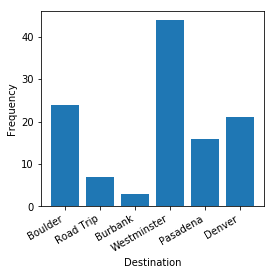

In [12]:
import collections

counts = dict(collections.Counter(data.destinationIds))

f, axes = plot.subplots(1, 1)
f.autofmt_xdate()
f.set_size_inches(4, 4)

axes.bar(counts.keys(), counts.values())
axes.set_xlabel("Destination")
axes.set_xticks(counts.keys())
axes.set_xticklabels(map(lambda x : nameFromDestId[x], counts.keys()))
axes.set_ylabel("Frequency")

plot.show()

# Destination prediction
Goal: Can the destination be computed from the available data?

Confusion matrix:
[[ 8  0  1  2  0]
 [ 0  2  0  1  0]
 [ 0  0 13  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0  9]]
Accuracy: 0.89


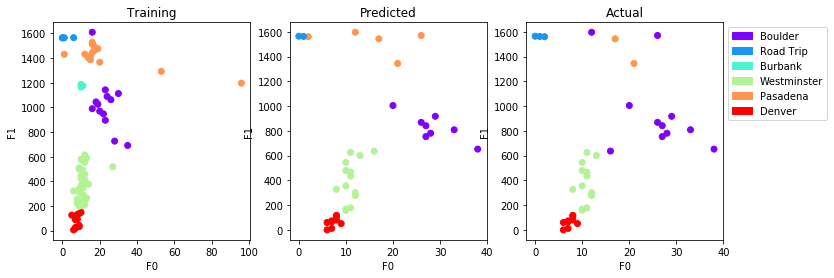

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

minDate = min(data.fromDates)
dates = numpy.array(map(lambda x : (x - minDate).total_seconds() / 60 / 60 / 24, data.fromDates))

# time since prev event, time of event
features = numpy.column_stack((data.daysBetween, dates))
trainX, testX, trainY, testY = train_test_split(features, data.destinationIds, test_size=0.33)

model = GaussianNB()
model.fit(trainX, trainY)
predictY = model.predict(testX)

M = confusion_matrix(testY, predictY)
print "Confusion matrix:\n", M
print "Accuracy: %.2f" % accuracy_score(testY, predictY)

f, axes = plot.subplots(1, 3)
f.set_size_inches(12, 4)

axes[0].scatter(trainX[:,0], trainX[:,1], c = map(lambda x : colorFromDestId[x], trainY))
axes[0].set_xlabel("F0")
axes[0].set_ylabel("F1")
axes[0].set_title("Training")

axes[1].scatter(testX[:,0], testX[:,1], c = map(lambda x : colorFromDestId[x], predictY))
axes[1].set_xlabel("F0")
axes[1].set_ylabel("F1")
axes[1].set_title("Predicted")

axes[2].scatter(testX[:,0], testX[:,1], c = map(lambda x : colorFromDestId[x], testY))
axes[2].set_xlabel("F0")
axes[2].set_ylabel("F1")
axes[2].set_title("Actual")

axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()